In [14]:
# imports
import anndata
import numpy
%matplotlib inline
import importlib.util
import sys
# spec = importlib.util.spec_from_file_location("novosparc", "/home/vfs/PycharmProjects/rajewskyLab/novosparc/novosparc/__init__.py")
spec = importlib.util.spec_from_file_location("novosparc", "/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py")
novosparc = importlib.util.module_from_spec(spec)
sys.modules["novosparc"] = novosparc
spec.loader.exec_module(novosparc)
# import novosparc

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
plt.viridis()
from matplotlib.gridspec import GridSpec
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import zscore

from sklearn.preprocessing import scale

# Gaussian mixture model
from sklearn.mixture import BayesianGaussianMixture

import random
random.seed(0)

<Figure size 432x288 with 0 Axes>

In [15]:
# function taken from: https://www.cbrinton.net/ECE20875-2020-Spring/W11/gmms_notebook.pdf
 # Plot function
def plot_mixture(gmm, X, show_legend=True, ax=None, upper_y_lim=4,x_lim=2):
    if ax is None:
        ax = plt.gca()

    # Compute PDF of whole mixture
    x = np.linspace(-6, 6, 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)

    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    # Plot data histogram
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label
    ='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')

    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    ax.set_ylim(0,upper_y_lim)
    ax.set_xlim(-x_lim,x_lim)
    if show_legend:
        ax.legend()

### Test on Drosophila example

In [11]:
sdge = np.genfromtxt("droso_sdge.csv", delimiter=",")
sdge[:4]

array([[0.00038766, 0.0007229 , 0.00060221, ..., 0.00042215, 0.00026123,
        0.00028144],
       [0.00034564, 0.00041143, 0.00033722, ..., 0.00049134, 0.00023148,
        0.00032714],
       [0.00271143, 0.00279895, 0.0027824 , ..., 0.00282162, 0.00283892,
        0.00279376],
       [0.00181152, 0.00193682, 0.00191349, ..., 0.00178839, 0.00177586,
        0.00183776]])

In [8]:
# Reading expression data to scanpy AnnData (cells x genes) - here I only need this for the gene names
# although I probably also could just safe the gene names
# single cell data
data_dir = '../../../novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()

# FISH atlas
atlas_dir = '../../../novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039 # number of spots derived from the spatial data
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values
locations = locations_apriori
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

<ipython-input-16-516ee0acf221>:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


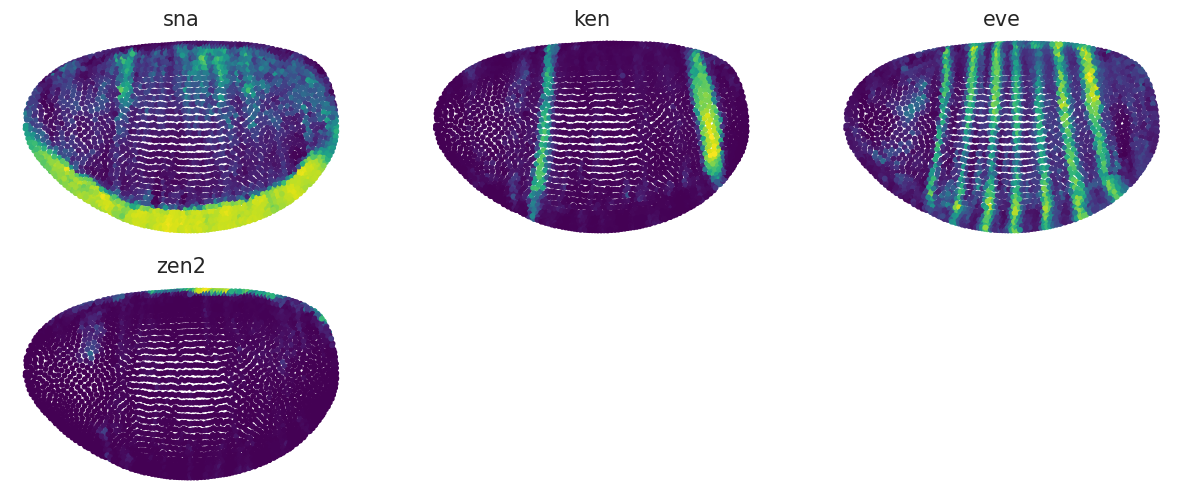

<Figure size 432x288 with 0 Axes>

In [16]:
# test original reconstructed expression of individual genes
pl_genes = ['sna', 'ken', 'eve', 'zen2']
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

#title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]

novosparc.pl.embedding(dataset_reconst, pl_genes)

## Make a minimal Test set with the three important genes

In [17]:
sdge_test_cols = []
for i, gene in enumerate(pl_genes):
    if gene in dataset_reconst.var_names:
        sdge_test_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1,1))
sdge_test = np.concatenate(sdge_test_cols, axis=1)


### Different normalizing strategies

# normalize using zscore
sdge_test_normed_zscore = zscore(sdge_test)

# log transform
sdge_test_normed_log = np.log(sdge_test)

# min-max (unprefered)
def min_max_norm(numpy_array):
    array_normed_minmax = (numpy_array - np.min(numpy_array))/ (np.max(numpy_array) - np.min(numpy_array))

    return array_normed_minmax

sdge_test_normed_minmax = min_max_norm(sdge_test)

# scaling
sdge_test_scaled = scale(sdge_test)


/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


## Normalizations

I need to normalize the matrix before I can use the Gaussian Mixture Model. Here I init and try the different normalization methods possible and check with box-plots what they do to the data. I inlcude Min-Max normalization here although it is not recommended to use this (according to Artür)

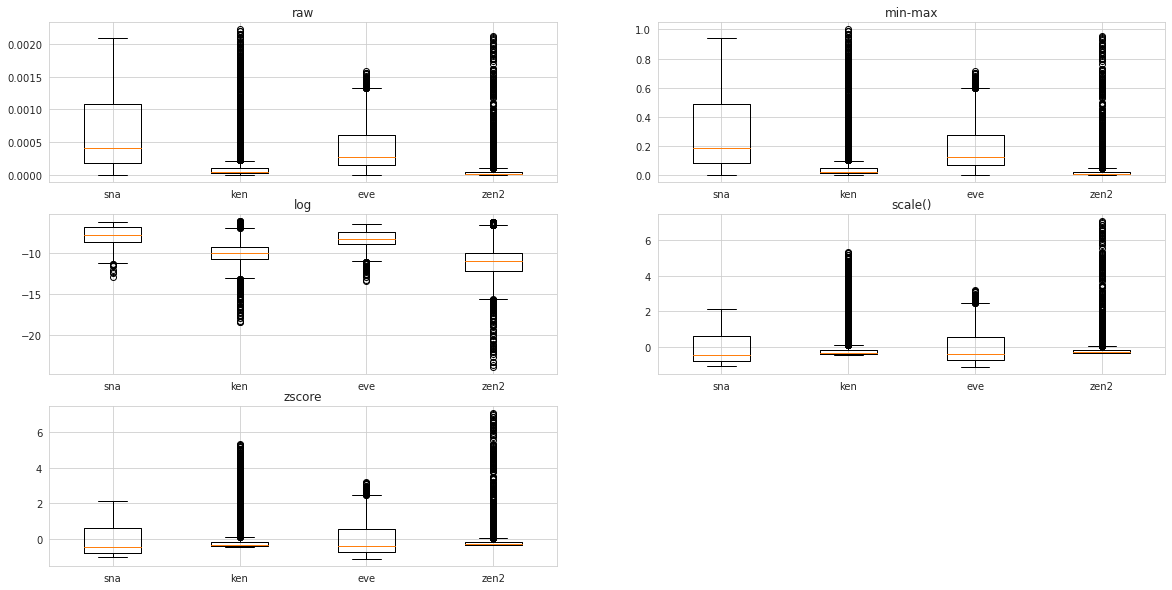

In [18]:
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(nrows=3, ncols=2)

# ToDo do this in a loop

# raw (UMI normalized, see paper methods)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_title("raw")
ax0.boxplot(sdge_test, labels=pl_genes);
# min-max
ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title("min-max")
ax1.boxplot(sdge_test_normed_minmax, labels=pl_genes);
# log
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title("log")
ax2.boxplot(sdge_test_normed_log, labels=pl_genes);
# scale/standardize
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("scale()")
ax3.boxplot(sdge_test_scaled, labels=pl_genes);
# z-score
ax4 = fig.add_subplot(gs[2, 0])
ax4.set_title("zscore")
ax4.boxplot(sdge_test_normed_zscore, labels=pl_genes);


In [19]:
# help(plt.boxplot)

## Debugging: single test and plotting

### Make a debugging set

In [20]:
# debugging_genes = ["sna", "aay", "Ama", "CG43394"]
debugging_genes = ["sna", "CG43394"]

sdge_test_cols = []
for i, gene in enumerate(debugging_genes):
    if gene in dataset_reconst.var_names:
        sdge_test_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1,1))
sdge_debugging = np.concatenate(sdge_test_cols, axis=1)

# zscore normalize
sdge_debug_normed_zscore = zscore(sdge_debugging)
# log
sdge_debug_normed_log = np.log(sdge_debugging)
# scale
sdge_debug_normed_scale = scale(sdge_debugging)

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
True
True
0    2384
1     655
dtype: int64


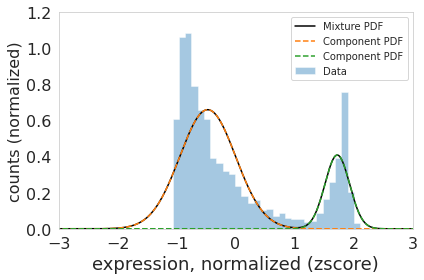

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False
True
True
1    1551
0    1488
dtype: int64


/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


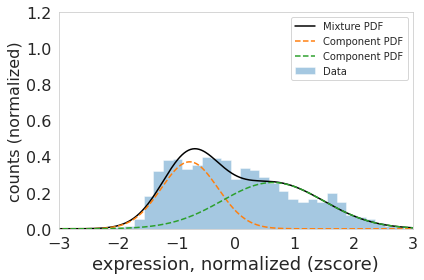

In [32]:
for i, gene in enumerate(sdge_test_cols):
    sngl_gn = sdge_debug_normed_zscore[:,i].reshape(-1,1)
    # sngl_gn = sdge_debug_normed_log[:,i].reshape(-1,1)
    # sngl_gn = sdge_debug_normed_scale[:,i].reshape(-1,1)

    gmm = BayesianGaussianMixture(n_components=2, verbose=1).fit(sngl_gn.reshape(-1,1))

    # # get label for distributions
    labels = gmm.predict(sngl_gn.reshape(-1,1))
    print(0 in labels)
    print(1 in labels)
    # count locations per distribution
    print(pd.Series(labels).value_counts())

    x_lim_range = np.abs(np.ceil(gmm.means_[0])) +3

    plot_mixture(gmm, sngl_gn,upper_y_lim=1.2,x_lim=x_lim_range);
    plt.grid(False)
    plt.xlabel('expression, normalized (zscore)', fontsize=18)
    plt.ylabel('counts (normalized)', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.show()


# Bayesian GMM

## test on genes

In [23]:
# from _tissue
uncleaned_matrix = sdge_debug_normed_zscore
uncleaned_matrix_dict = pd.DataFrame(uncleaned_matrix.T).to_dict('records')
# apply model and filtering
modded_cols = []
cov_prior = None

for row in uncleaned_matrix_dict:

    # transform to array
    expression_values = np.asarray(list(row.values())).reshape(-1, 1)

    # apply model
    if cov_prior is None:
        gmm = BayesianGaussianMixture(n_components=2).fit(expression_values)
    else:
        # widen the fitted curves to include more expression values of the defaults distributions edges
        gmm = BayesianGaussianMixture(n_components=2,
      covariance_prior=cov_prior).fit(expression_values)
    # get labels for distributions
    labels = gmm.predict(expression_values)

    # merge labels column with original expression value column
    label_assignment = np.concatenate((expression_values, labels.reshape(-1, 1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO: I would like to write this stuff without those magic numbers (if even possible in python?)
    # only apply sorting when 2 distributions or more were modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist oF choice (has the distribution with the higher values), labels have to be inverted for multiplication
        if gmm.means_[0] > gmm.means_[1]:
            # invert labels
            label_assignment[:, 1] = np.logical_not(label_assignment[:, 1]).astype(int)

        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:, 0] *= label_assignment[:, 1]

    # build a list of modified columns
    modded_cols.append(label_assignment[:, 0].reshape(-1, 1))

modded_matrix = np.concatenate(modded_cols, axis=1)

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [16]:
gmm.means_[0] > gmm.means_[1]

array([False])

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_66040/1305984124.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_cleaned_zscore = sc.AnnData(pd.DataFrame(modded_matrix, columns=debugging_genes))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


reconstruction


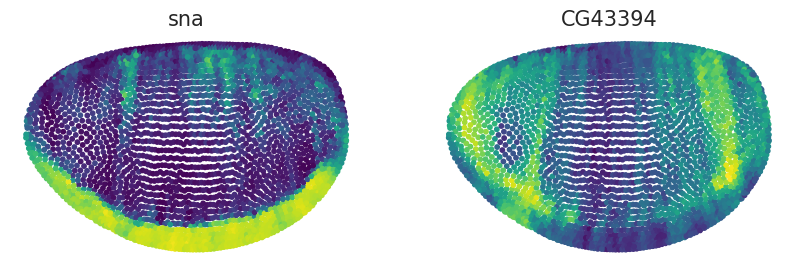

zscore


<Figure size 432x288 with 0 Axes>

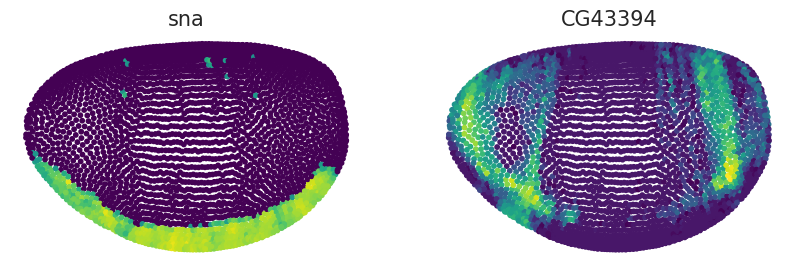

<Figure size 432x288 with 0 Axes>

In [24]:
dataset_test = sc.AnnData(pd.DataFrame(sdge_debug_normed_zscore, columns=debugging_genes))
dataset_cleaned_zscore = sc.AnnData(pd.DataFrame(modded_matrix, columns=debugging_genes))

dataset_cleaned_zscore.obsm['spatial'] = locations
dataset_test.obsm['spatial'] = locations

# plot
print("reconstruction")
novosparc.pl.embedding(dataset_test, debugging_genes)
print("zscore")
novosparc.pl.embedding(dataset_cleaned_zscore, debugging_genes)

In [13]:
%%time

# using zscore normalized

sdge_modded_cols = []

for column in sdge_test_normed_zscore.T:
    # apply model
    gmm = BayesianGaussianMixture(n_components=2,
                                  random_state=1138,
                              covariance_prior=[(200,)],
                               ).fit(column.reshape(-1,1))
    # get labels< for distributions
    labels = gmm.predict(column.reshape(-1,1))

    # merge labels column with original expression value column
    label_assignment = np.concatenate((column.reshape(-1,1),
                                   labels.reshape(-1,1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO I would like to write this stuff without those magic numbers
    # only apply sorting when 2 distributions where modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
        if vl_cnts[0] < vl_cnts[1]:
            # invert labels
            label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:,0] *= label_assignment[:,1]

    # build a list of modified columns
    sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))

sdge_modded_zscore = np.concatenate(sdge_modded_cols, axis=1)

CPU times: user 1.03 s, sys: 39.6 ms, total: 1.07 s
Wall time: 113 ms


In [ ]:
%%time
# using zscore normalized
# using pandas dictionary iteration

iterable_matrix = pd.DataFrame(sdge_test_normed_zscore.T).to_dict('records')

In [107]:
%%time
sdge_modded_cols = []

for row in iterable_matrix:

    # transform to array
    expression_values = np.asarray(list(row.values())).reshape(-1,1)
    # apply model
    gmm = BayesianGaussianMixture(n_components=2,
                                  random_state=1138,
                                 covariance_prior=[(200,)]
                               ).fit(expression_values)
    # get labels< for distributions
    labels = gmm.predict(expression_values)

    # merge labels column with original expression value column
    label_assignment = np.concatenate((expression_values,
                                      labels.reshape(-1,1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO I would like to write this stuff without those magic numbers
    # only apply sorting when 2 distributions where modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
        if vl_cnts[0] < vl_cnts[1]:
            # invert labels
            label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:,0] *= label_assignment[:,1]

    # build a list of modified columns
    sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))

sdge_modded_zscore = np.concatenate(sdge_modded_cols, axis=1)

CPU times: user 427 ms, sys: 0 ns, total: 427 ms
Wall time: 90.9 ms


In [72]:
np.asarray(list(iterable_matrix[0].values()))

array([-0.38857064,  0.0219252 , -0.31913099, ...,  1.66069317,
        1.91668987, -0.6467365 ])

In [71]:
sdge_test_normed_zscore.T[0]

array([-0.38857064,  0.0219252 , -0.319131  , ...,  1.6606932 ,
        1.9166899 , -0.6467365 ], dtype=float32)

In [39]:
%%time
a = []
for row in sdge.T:
    a.append(sum(row))
print(a[:5])

[4.309194234134786, 4.411718763430053, 4.358848721704179, 4.364047556285719, 4.512246776294351]
CPU times: user 2.73 s, sys: 0 ns, total: 2.73 s
Wall time: 2.73 s


In [28]:
df = pd.DataFrame(sdge.T)

In [40]:
%%time
a = []
for row in df.values:
    a.append(sum(row))
print(a[:5])

[4.309194234134786, 4.411718763430053, 4.358848721704179, 4.364047556285719, 4.512246776294351]
CPU times: user 2.56 s, sys: 0 ns, total: 2.56 s
Wall time: 2.56 s


In [41]:
%%time
a = []
for idx,row in df.iterrows():
    a.append(sum(row))
print(a[:5])

[4.309194234134786, 4.411718763430053, 4.358848721704179, 4.364047556285719, 4.512246776294351]
CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.07 s


In [35]:
df_dict = df.to_dict('records')

In [49]:
%%time
a = []
for row in df_dict:
    a.append(sum(row.values()))
print(a[:5])

[4.309194234134786, 4.411718763430053, 4.358848721704179, 4.364047556285719, 4.512246776294351]
CPU times: user 239 ms, sys: 0 ns, total: 239 ms
Wall time: 237 ms


In [48]:
sum(df_dict[0].values())

4.309194234134786

In [50]:
%%time

df = pd.DataFrame(sdge.T)
df_dict = df.to_dict('records')

CPU times: user 11.1 s, sys: 210 ms, total: 11.3 s
Wall time: 11.3 s


dict

CPU times: user 2.33 s, sys: 775 ms, total: 3.1 s
Wall time: 3.09 s


[0.00038765673743265336, 0.00034564187080429694, 0.0027114262971045903, 0.001811515088236723, 0.0008954633835104426]
CPU times: user 3.15 s, sys: 80.3 ms, total: 3.23 s
Wall time: 3.23 s


# test it

original


/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_5744/319656001.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_cleaned_zscore = sc.AnnData(pd.DataFrame(sdge_modded_zscore, columns=pl_genes))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


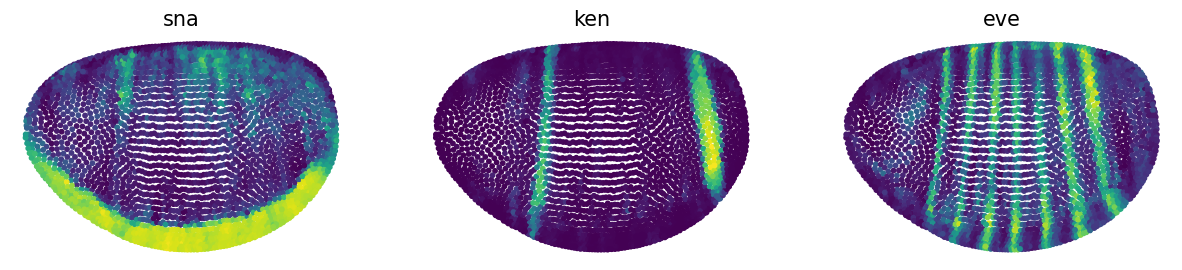

zscore


<Figure size 432x288 with 0 Axes>

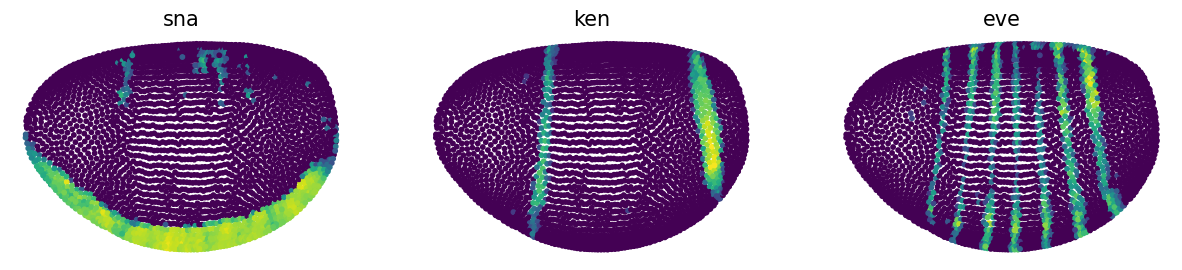

<Figure size 432x288 with 0 Axes>

In [13]:
one_gene = ['sna']
dataset_test = sc.AnnData(pd.DataFrame(sdge_test, columns=pl_genes))
# test cleaned reconstructed expression of individual genes
# dataset_cleaned_minmax = sc.AnnData(pd.DataFrame(sdge_modded_minmax, columns=pl_genes))
# dataset_cleaned_log = sc.AnnData(pd.DataFrame(sdge_modded_log, columns=pl_genes))
dataset_cleaned_zscore = sc.AnnData(pd.DataFrame(sdge_modded_zscore, columns=pl_genes))

# dataset_small = sc.AnnData(pd.DataFrame(sdge_small, columns=one_gene))
# dataset_cleaned_minmax.obsm['spatial'] = locations
# dataset_cleaned_log.obsm['spatial'] = locations
dataset_cleaned_zscore.obsm['spatial'] = locations
dataset_test.obsm['spatial'] = locations
#dataset_small.obsm['spatial'] = locations

# plot
print("original")
novosparc.pl.embedding(dataset_test, pl_genes)
# print("normalized minmax")
# novosparc.pl.embedding(dataset_cleaned_minmax, pl_genes)
# print("normalized log transformed")
# novosparc.pl.embedding(dataset_cleaned_log, pl_genes)
print("zscore")
novosparc.pl.embedding(dataset_cleaned_zscore, pl_genes)

In [14]:
len(pl_genes)

3

# Test on full matrix

In [15]:
# %%time
# # using zscore normalized
# # normalize using zscore
# sdge_normed_zscore = zscore(sdge)
#
#
# sdge_modded_cols = []
#
# for column in sdge_normed_zscore.T:
#     # apply model
#     gmm = BayesianGaussianMixture(n_components=2,
#                                  covariance_prior=[(200,)],
#                                ).fit(column.reshape(-1,1))
#     # get labels< for distributions
#     labels = gmm.predict(column.reshape(-1,1))
#
#     # merge labels column with original expression value column
#     label_assignment = np.concatenate((column.reshape(-1,1),
#                                    labels.reshape(-1,1)), axis=1)
#
#     # check how many labels and how many values per label
#     vl_cnts = pd.Series(labels).value_counts()
#
#     # TODO I would like to write this stuff without those magic numbers
#     # only apply sorting when 2 distributions where modelled
#     if len(vl_cnts) > 1:
#         # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
#         if vl_cnts[0] < vl_cnts[1]:
#             # invert labels
#             label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
#         # multiply expression values with label values so that the 0 dist values are effectively removed
#         label_assignment[:,0] *= label_assignment[:,1]
#
#     # build a list of modified columns
#     sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))
#
# sdge_modded_zscore = np.concatenate(sdge_modded_cols, axis=1)

CPU times: user 30min 52s, sys: 51min 30s, total: 1h 22min 22s
Wall time: 20min 24s


In [108]:
%%time
# using zscore normalized
# using pandas dictionary iteration

# normalize using zscore
sdge_normed_zscore = zscore(sdge)

iterable_matrix = pd.DataFrame(sdge_normed_zscore.T).to_dict('records')

CPU times: user 9.94 s, sys: 415 ms, total: 10.4 s
Wall time: 10.4 s


In [109]:
%%time
sdge_modded_cols = []

for row in iterable_matrix:

    # transform to array
    expression_values = np.asarray(list(row.values())).reshape(-1,1)
    # apply model
    gmm = BayesianGaussianMixture(n_components=2,
                                  random_state=1138,
                                 covariance_prior=[(200,)]
                               ).fit(expression_values)
    # get labels< for distributions
    labels = gmm.predict(expression_values)

    # merge labels column with original expression value column
    label_assignment = np.concatenate((expression_values,
                                      labels.reshape(-1,1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO I would like to write this stuff without those magic numbers
    # only apply sorting when 2 distributions where modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
        if vl_cnts[0] < vl_cnts[1]:
            # invert labels
            label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:,0] *= label_assignment[:,1]

    # build a list of modified columns
    sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))

sdge_modded_zscore = np.concatenate(sdge_modded_cols, axis=1)

CPU times: user 37min 15s, sys: 1h 5min 51s, total: 1h 43min 7s
Wall time: 9min 15s


original


/tmp/ipykernel_5744/2984976038.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_cleaned_zscore_wholematrix = sc.AnnData(pd.DataFrame(sdge_modded_zscore.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


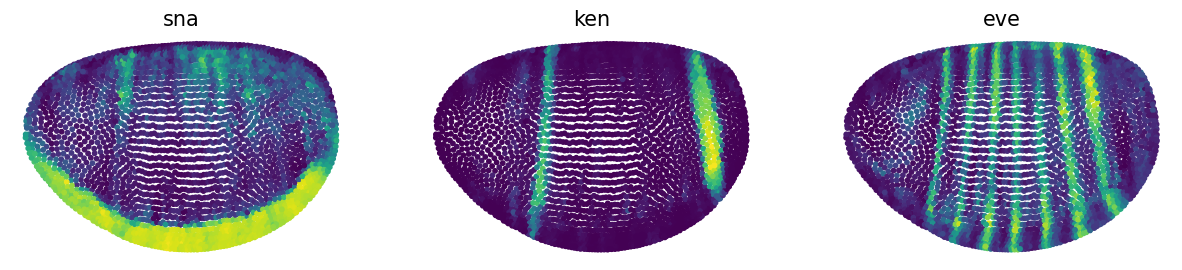

zscore


<Figure size 432x288 with 0 Axes>

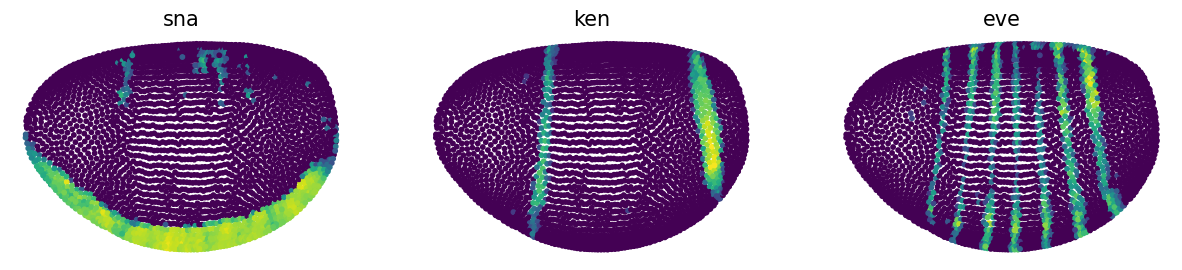

whole matrix cleanup


<Figure size 432x288 with 0 Axes>

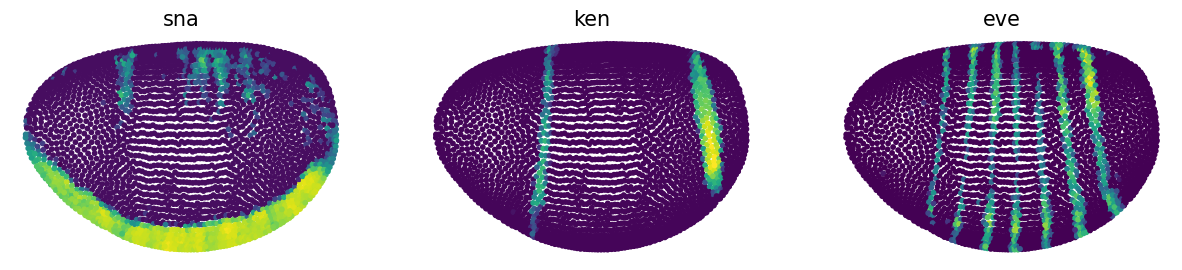

<Figure size 432x288 with 0 Axes>

In [16]:

# test cleaned reconstructed expression of individual genes

dataset_cleaned_zscore_wholematrix = sc.AnnData(pd.DataFrame(sdge_modded_zscore.T, columns=gene_names))
dataset_cleaned_zscore_wholematrix.obsm['spatial'] = locations

# plot
print("original")
novosparc.pl.embedding(dataset_test, pl_genes)
print("zscore")
novosparc.pl.embedding(dataset_cleaned_zscore, pl_genes)
print("whole matrix cleanup")
novosparc.pl.embedding(dataset_cleaned_zscore_wholematrix, pl_genes)